In [51]:
import pennylane as qml
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from pennylane.optimize import NesterovMomentumOptimizer

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

In [52]:
data = load_iris()
X = data.data
y = data.target

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.3, random_state=42)

In [53]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
clf = LogisticRegression(multi_class='multinomial', max_iter=500)
clf.fit(X_train, y_train)

y_pred_classical = clf.predict(X_test)
accuracy_classical = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_classical, axis=1))

print(f'classical model accuracy: {accuracy_classical}')

ValueError: y should be a 1d array, got an array of shape (105, 3) instead.

## Binary classification of iris dataset

In [37]:
data = load_iris()
X = data.data
y = data.target

In [38]:
#select only two classes
binary_indices = y < 2
X = X[binary_indices]
y = y[binary_indices]

X = X[:, :2]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [40]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred_classical = clf.predict(X_test)
accuracy_classical = accuracy_score(y_test, y_pred_classical)

print(f'classical model accuracy: {accuracy_classical}')

classical model accuracy: 1.0


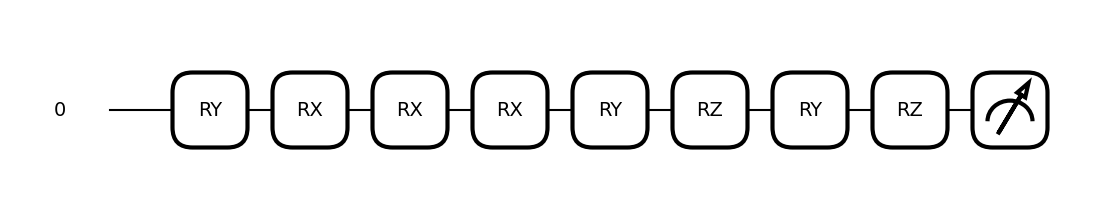

In [41]:
dev = qml.device('default.qubit', wires=1)

@qml.qnode(dev)
def circuit(params, x):
    #encode data to quantum state
    qml.RY(x[0], wires=0)
    qml.RX(x[1], wires=0)

    #encode missing features
    # qml.RX(x[2], wires=0)
    # qml.RX(x[3], wires=0)
    
    #apply trainable gates
    qml.RY(params[0], wires=0)
    qml.RZ(params[1], wires=0)

    #apply trainable gates to missing parameters
    # qml.RY(params[2], wires=0)
    # qml.RZ(params[3], wires=0)
    
    return qml.expval(qml.PauliZ(0))

params = np.random.uniform(-np.pi, np.pi, 2)

# params = np.random.uniform(-np.pi, np.pi, 4)

params = qml.numpy.array(params, requires_grad = True)

fig, ax = qml.draw_mpl(circuit)(params, X_train)
fig.show()

In [42]:
def cost(params, X, y):
    predictions = [circuit(params, x) for x in X]
    # return np.mean((np.array(predictions) - y) ** 2)
    return qml.numpy.mean((qml.numpy.array(predictions) - y) ** 2)

In [43]:
optimizer = NesterovMomentumOptimizer(stepsize=0.1)

In [44]:
epochs = 50
for epoch in range(epochs):
    params = optimizer.step(lambda p: cost(p, X_train, y_train), params)
    print(f'epoch {epoch+1} | cost: {cost(params, X_train, y_train)}')

epoch 1 | cost: 1.467819221870359
epoch 2 | cost: 1.3784292294078948
epoch 3 | cost: 1.32364359310093
epoch 4 | cost: 1.3084809700728408
epoch 5 | cost: 1.3161333180607095
epoch 6 | cost: 1.3293749438190854
epoch 7 | cost: 1.3381340431882949
epoch 8 | cost: 1.3390086372434977
epoch 9 | cost: 1.3330003831264867
epoch 10 | cost: 1.3234727101493666
epoch 11 | cost: 1.3143581902880028
epoch 12 | cost: 1.3085211873592257
epoch 13 | cost: 1.3067112545290833
epoch 14 | cost: 1.3076893523225004
epoch 15 | cost: 1.3094092123224592
epoch 16 | cost: 1.3103342615073725
epoch 17 | cost: 1.310032390212048
epoch 18 | cost: 1.3089377995290825
epoch 19 | cost: 1.3077482812943104
epoch 20 | cost: 1.3069507440663486
epoch 21 | cost: 1.30666847126946
epoch 22 | cost: 1.306755403226659
epoch 23 | cost: 1.3069739159298603
epoch 24 | cost: 1.307135384225598
epoch 25 | cost: 1.3071596589978656
epoch 26 | cost: 1.3070642964067365
epoch 27 | cost: 1.3069171348676496
epoch 28 | cost: 1.3067860387807302
epoch 29 

In [45]:
y_pred_quantum = qml.numpy.array([1 if circuit(params, x) > 0 else 0 for x in X_test])
accuracy_quantum = accuracy_score(y_test, y_pred_quantum)
print(f'quantum accuracy: {accuracy_quantum}')

quantum accuracy: 0.6222222222222222


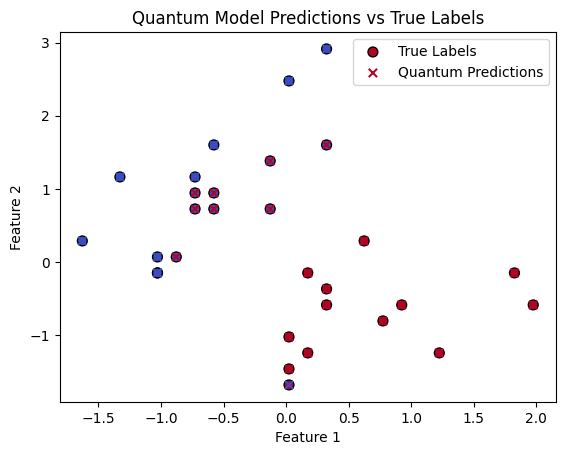

In [24]:
# Scatter plot of the true labels
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label="True Labels", cmap=plt.cm.coolwarm, s=50, edgecolors="k")

# Scatter plot of the quantum predictions
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_quantum, marker="x", label="Quantum Predictions", cmap=plt.cm.coolwarm)

# Add plot details
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Quantum Model Predictions vs True Labels")
plt.show()

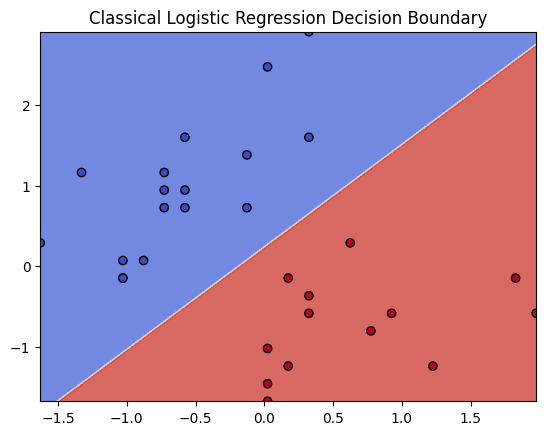

In [23]:
import matplotlib.pyplot as plt

# Plot the decision boundary for the classical model
xx, yy = np.meshgrid(np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100),
                     np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors="k", cmap=plt.cm.coolwarm)
plt.title("Classical Logistic Regression Decision Boundary")
plt.show()

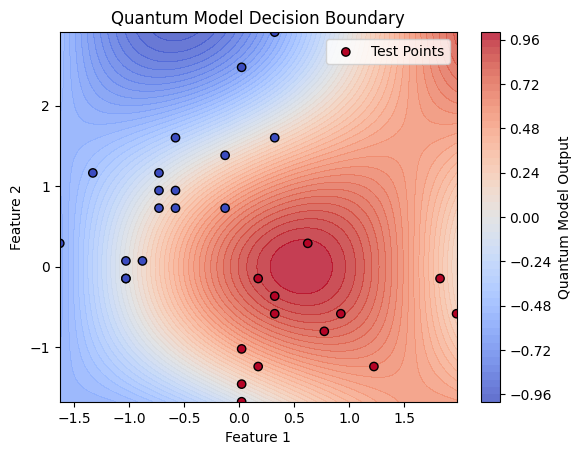

In [25]:
# Generate a grid of points
xx, yy = np.meshgrid(np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100),
                     np.linspace(X_test[:, 1].min(), X_test[:, 1].max(), 100))

# Evaluate the quantum circuit at each grid point
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = np.array([circuit(params, point) for point in grid_points])
grid_predictions = grid_predictions.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, grid_predictions, levels=50, cmap=plt.cm.coolwarm, alpha=0.8)
plt.colorbar(label="Quantum Model Output")

# Overlay test points with true labels
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, edgecolors="k", cmap=plt.cm.coolwarm, label="Test Points")
plt.title("Quantum Model Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


## Extra experiments

In [3]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred_classical = log_reg.predict(X_test)
accuracy_classical = accuracy_score(y_test, y_pred_classical)

print(f'Classical model accuracy: {accuracy_classical}')

Classical model accuracy: 0.8333333333333334


In [6]:
dev = qml.device('default.qubit', wires=1)

def quantum_circuit(p, x):
    qml.RY(x, wires=0)
    qml.RX(p[0], wires=0)
    qml.RZ(p[1], wires=0)
    return qml.expval(qml.PauliZ(0))

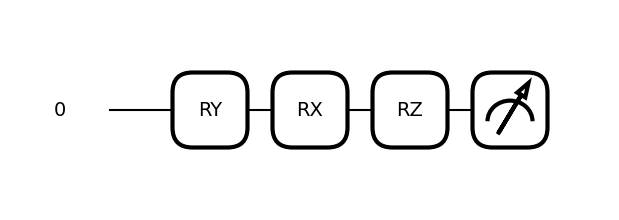

In [7]:
@qml.qnode(dev)
def circuit(p, x):
    return quantum_circuit(p, x)

# inputs = np.random.rand(wires)
# weights = np.random.rand(3, wires, 3)

# params = np.random.uniform(-np.pi, np.pi, 2)
penny_params = pnp.array(np.random.uniform(-np.pi, np.pi, 2), requires_grad=True)

# fig, ax = qml.draw_mpl(qnode)(inputs, weights)
fig, ax = qml.draw_mpl(circuit)(penny_params, X_train)
fig.show()

In [15]:
def cost(p, X, y):
    predictions = pnp.array([circuit(p, x) for x in X])
    return pnp.mean((predictions - y) ** 2)

In [16]:
optimizer = NesterovMomentumOptimizer(stepsize=0.1)

In [17]:
# X_train_scaled = (X_train[:, 0] + 1) * (np.pi / 2)
# X_test_scaled = (X_test[:, 0] + 1) * (np.pi / 2)

X_train_scaled = (pnp.array(X_train[:, 0]) + 1) * (pnp.pi / 2)
X_test_scaled = (pnp.array(X_test[:, 0]) + 1) * (pnp.pi / 2)

In [18]:
print(penny_params)

[-0.27602043  1.79181341]


In [19]:
epochs = 50
for epoch in range(epochs):
    params = optimizer.step(lambda p: cost(p, X_train[:, 0], y_train), penny_params)

print(f'trained quantum parameters: {params}')

trained quantum parameters: [-0.50366028  1.79181341]


In [20]:
y_pred_quantum = pnp.array([1 if circuit(penny_params, x) > 0 else 0 for x in X_test[:, 0]])
accuracy_quantum = accuracy_score(y_test, y_pred_quantum)

In [21]:
print(f'quantum model accuracy: {accuracy_quantum}')

quantum model accuracy: 0.5
